Spectral Analysis for Strobosopic Stimulation

In [7]:
# Let's load an audio file uploaded to Google Colab
# We can extract amplitude and peak frequency from these audio data as well as
# the time stamps at which these data are extracted from

import librosa
import numpy as np

y, sr = librosa.load('/jupiter.mp3')
stft = np.abs(librosa.stft(y))
frequencies = librosa.fft_frequencies(sr=sr)
times = librosa.frames_to_time(np.arange(stft.shape[1]), sr=sr)

In [8]:
# Let's save this data into a .csv just to verify that these are transmutable data

import pandas as pd

# Prepare the data for saving
data = []
for i, time in enumerate(times):
    for j, freq in enumerate(frequencies):
        amplitude = stft[j, i]
        data.append([freq, amplitude, time])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Frequency', 'Amplitude', 'Time'])

# Save to CSV
df.to_csv('frequency_amplitude_time_all.csv', index=False)

In [9]:
# These tools are incredibly powerful, so our generated .csv is a bit hefty to work with;
# we'll need to parse these data to isolate the
# dominant frequency per time slice (as chosen by that with highest amplitude per repeated time stamp)
# as well as the amplitude at which this occurs.
# We'll also now be able to go down to a single time stamp per
# stroboscopic value

# Load the previously generated DataFrame
df = pd.read_csv('frequency_amplitude_time_all.csv')

# Group by time and select the row with the maximum amplitude for each time slice
dominant_tones = df.loc[df.groupby('Time')['Amplitude'].idxmax()]

# Save the result to a new CSV file
dominant_tones.to_csv('dominant_freq_amp_time.csv', index=False)

In [10]:
# Let's generate a corresponding frequency array so that the light plays
# the same frequency as the music in a different octave.
# Because of our interest in intermodulation distortion, we can also
# transpose the photic data down by a major third
# to try and generate more spurious components that may contribute to
# stroboscopic experience.

# We will also transmute our amplitude values and scale them in accordance with
# the parameters of our strobe device such that
# the maximum value of a song becomes the maximum brightness value of the light (255)
# with all other values scaled accordingly.

# Note names and corresponding frequencies, C0 to C8
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
frequencies = [16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50, 25.96, 27.50, 29.14, 30.87,
               32.70, 34.65, 36.71, 38.89, 41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74,
               65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,
               130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,
               261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
               523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,
               1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53,
               2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07,
               4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13]

# These are the frequencies of subcontra C-1 to B-1
correspondingFreqArray = [8.18, 8.66, 9.18, 9.72, 10.3, 10.91, 11.56, 12.25, 12.98, 13.75, 14.57, 15.43, 16.36]

# These are the frequencies of subsubcontra Ab-2 to subcontra G-1
# as transposing the photic input down by a major third
# may generate more spurious audiovisual interactions
relativeFreqArray = [6.54, 6.93, 7.34, 7.78, 8.18, 8.66, 9.18, 9.72, 10.3, 10.91, 11.56, 12.25, 12.98]

# Function to find the closest note and calculate the deviation
def find_note_and_deviation(freq):
    idx = (np.abs(np.array(frequencies) - freq)).argmin()
    closest_freq = frequencies[idx]
    deviation = freq - closest_freq
    note = note_names[idx % 12] + str(int(idx / 12))  # Octave calculation
    return note, deviation

# Function to adjust corresponding and relative frequencies based on deviation and fit within valid range
def adjust_frequencies(deviation, base_idx):
    adj_corr_freq = correspondingFreqArray[base_idx % len(correspondingFreqArray)] + deviation
    adj_rel_freq = relativeFreqArray[base_idx % len(relativeFreqArray)] + deviation

    # Ensure that the adjusted frequencies are within the valid range
    while adj_corr_freq > max(correspondingFreqArray):
        adj_corr_freq /= 2
    while adj_rel_freq > max(relativeFreqArray):
        adj_rel_freq /= 2

    return adj_corr_freq, adj_rel_freq

# Load your data
df = pd.read_csv('dominant_freq_amp_time.csv')

# Apply the functions
df['Note'], df['Deviation'] = zip(*df['Frequency'].apply(find_note_and_deviation))
df[['Adjusted_Corr_Freq', 'Adjusted_Rel_Freq']] = df.apply(
    lambda row: pd.Series(adjust_frequencies(row['Deviation'], note_names.index(row['Note'][:-1]))), axis=1)

# Replace negative values with zero
df['Adjusted_Corr_Freq'] = df['Adjusted_Corr_Freq'].apply(lambda x: max(x, 0))
df['Adjusted_Rel_Freq'] = df['Adjusted_Rel_Freq'].apply(lambda x: max(x, 0))

# Scale amplitude values to the range [1, 255], but set to 0 if the frequency is 0
max_amplitude = df['Amplitude'].max()
df['Scaled_Amplitude'] = df.apply(
    lambda row: 0 if row['Adjusted_Corr_Freq'] == 0 or row['Adjusted_Rel_Freq'] == 0 else max(1, int((row['Amplitude'] / max_amplitude) * 255)), axis=1
)

# Ask the user for the desired file name
file_name = input("Please enter the desired file name (without extension): ") + ".csv"

# Save the updated DataFrame to the user-specified file name
df.to_csv(file_name, index=False)

print(f"File saved as {file_name}")

Please enter the desired file name (without extension): jupiter
File saved as jupiter.csv


Choose frequency type: (1) Corresponding Frequencies, (2) Relative Frequencies: 2
Using Relative Frequencies.
Song length: 456.01668934240365 seconds


<ipython-input-14-f14ef2caecdb>:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


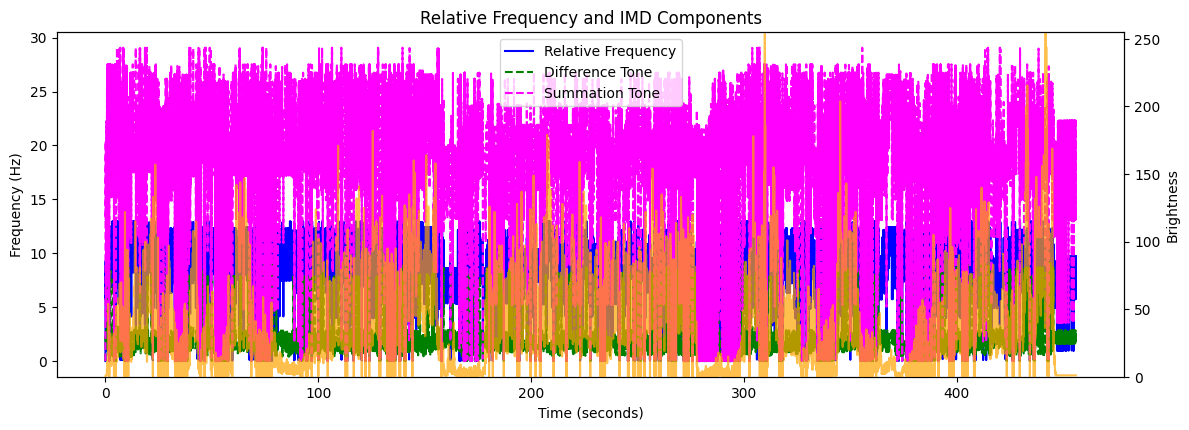

In [14]:
# Let's now plot these data per user input of condition

import matplotlib.pyplot as plt
from scipy.signal import square

# Load the data from the CSV file
data = pd.read_csv("jupiter.csv")

choice = input("Choose frequency type: (1) Corresponding Frequencies, (2) Relative Frequencies: ")

time = data['Time']

if choice == '1':
    frequency_values = data['Adjusted_Corr_Freq']
    print('Using Corresponding Frequencies.')
elif choice == '2':
    frequency_values = data['Adjusted_Rel_Freq']
    print('Using Relative Frequencies.')
else:
    raise ValueError("Invalid choice! Please choose either 1 or 2.")

brightness = data['Scaled_Amplitude']

# Calculate the song length in seconds
song_length = max(time) - min(time)
print(f'Song length: {song_length} seconds')

# Generate sample times
frame_duration_s = 1/2000
sample_times = np.arange(0, song_length, frame_duration_s)

# Interpolate frequencies and brightness
interpolated_freqs = np.interp(sample_times, time, frequency_values)
interpolated_brightness = np.interp(sample_times, time, brightness)

# Generate strobe waveform
avg_freq_since_start = np.cumsum(interpolated_freqs) / np.arange(1, len(interpolated_freqs) + 1)
strobe_duty_cycle = 50
strobe = (1 + square(2 * np.pi * sample_times * avg_freq_since_start, strobe_duty_cycle)) / 2

# Calculate IMD components based on the selected condition
if choice == '1':
    other_freq = data['Adjusted_Rel_Freq']
    label_condition = 'Corresponding Frequency'
elif choice == '2':
    other_freq = data['Adjusted_Corr_Freq']
    label_condition = 'Relative Frequency'

interpolated_other_freqs = np.interp(sample_times, time, other_freq)

difference_tones = np.abs(interpolated_freqs - interpolated_other_freqs)
summation_tones = interpolated_freqs + interpolated_other_freqs

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Frequency and IMD Components
plt.subplot(2, 1, 1)
plt.plot(sample_times, interpolated_freqs, label=label_condition, color='blue')
plt.plot(sample_times, difference_tones, label='Difference Tone', color='green', linestyle='--')
plt.plot(sample_times, summation_tones, label='Summation Tone', color='magenta', linestyle='--')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds)")
plt.legend()
plt.title(f'{label_condition} and IMD Components')

# Plot Brightness
plt.twinx()
plt.plot(sample_times, interpolated_brightness, label='Brightness', color='orange', alpha=0.7)
plt.ylabel("Brightness")
plt.ylim([0, 255])

plt.tight_layout()
plt.show()